### testing the importance of distance on instruction priority

In [2]:
%pip install huggingface_hub
%pip install python-dotenv
%pip install huggingface
%pip install datasets
%pip install transformers
%pip install matplotlib
%pip install accelerate


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To updat

In [3]:
import os
from dotenv import load_dotenv
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["DATASETS_DISABLE_PROGRESS_BAR"] = "1"

load_dotenv()
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

In [4]:
!hf auth login --token {huggingface_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.


Token is valid (permission: fineGrained).
The token `a3` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `a3`


In [23]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [6]:
#load wiki
ds = load_dataset("wikitext", "wikitext-2-raw-v1")

In [7]:
print(type(ds))
print(ds)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [8]:
print(ds["train"][7])

{'text': ' = = Gameplay = = \n'}


In [9]:
def keep_row(example):
    text = example['text']
    if not text:
        return False
    if text == "\n":
        return False
    # if text.startswith("="):
    #     return False
    return True

In [10]:
filtered_wiki = ds.filter(keep_row)

In [11]:
model_name = "google/gemma-2-9b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [12]:
### tokenize dataset
full_text = "\n".join([line for line in filtered_wiki["train"]["text"]])
all_tokens = tokenizer.encode(full_text, add_special_tokens = False)

In [13]:
def get_r_wiki_slice(n_tokens):
    start_idx = random.randint(0, len(all_tokens) - n_tokens - 1)
    return all_tokens[start_idx : start_idx + n_tokens]

In [14]:
system_prompt = "Your goal is to respond to the user's request while making sure his instructions are fully satistfied. An instruction will appear in the form 'Instruction: <INSTRUCTION>.'\n"

end_question = "\nNow, provide your response based on the previous instructions. \n"

instruction_set = {
    "language": ["Respond in French.", "Respond in German."],
    "first_word": ["Begin your response with the word 'CHERRY'.", "Begin your response with the word 'APPLE'."],
}


In [15]:
def find_token_span(target_ids, full_ids):
    n = len(target_ids)
    for i in range(len(full_ids) - n + 1):
        if full_ids[i : i + n] == target_ids:
            return i, i + n
    return None, None

In [16]:
def construct_single_instr_prompt(instr_text, pos_pct, total_length=1024):
    formatted_instr = f"\n\nInstruction: {instr_text}\n\n"
    
    instr_tokens = tokenizer.encode(formatted_instr, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    # calculate template overhead
    test_msg = [{"role": "user", "content": ""}]
    template_overhead = len(tokenizer.apply_chat_template(test_msg, tokenize=True, add_generation_prompt=True))
    
    # calculate filler budget
    fixed_len = len(sys_tokens) + len(instr_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_len
    
    if filler_budget < 0:
        raise ValueError(f"Prompt too long ({fixed_len}) for target length ({total_length})")
        
    # get filler
    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * filler_budget)
    
    # Decode only the wiki parts into strings
    pre_filler = tokenizer.decode(filler_tokens[:split_idx])
    post_filler = tokenizer.decode(filler_tokens[split_idx:])
    
    user_content = (
        system_prompt + 
        pre_filler + 
        formatted_instr + 
        post_filler + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )
    
    full_list = input_ids[0].tolist()
    instr_indices = find_token_span(instr_tokens, full_list)
    
    if input_ids.shape[1] != total_length:
        if input_ids.shape[1] > total_length:
            input_ids = input_ids[:, :total_length]
        else:
            padding = torch.full((1, total_length - input_ids.shape[1]), tokenizer.pad_token_id)
            input_ids = torch.cat([input_ids, padding.to(input_ids.device)], dim=1)

    indices = {
        "instruction": instr_indices,
        "response_start": input_ids.shape[1] - 1
    }
    
    return input_ids, indices

In [17]:
target_word = " CHERRY" 
target_token_id = tokenizer.encode(target_word, add_special_tokens=False)[0]

In [ ]:
def batched_position_sweep(model, instr_text, total_length, samples_per_pos=100, batch_size=8):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 11)
    target_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    
    results = {round(pct, 2): {"logits": [], "is_correct": []} for pct in pcts}
    sanity_checks = {round(pct, 2): "" for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        global_sample_idx = 0

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                ids, _ = construct_single_instr_prompt(instr_text, pct, total_length)
                batch_list.append(ids)
                global_sample_idx += 1 
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            cherry_logits = last_token_logits[:, target_token_id].cpu().tolist()
            results[pct_key]["logits"].extend(cherry_logits)
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_mask = (predictions == target_token_id).cpu().tolist()
            results[pct_key]["is_correct"].extend(correct_mask)

            if b == 0:
                prompt_text = tokenizer.decode(batch_tensor[0], skip_special_tokens=False)
                
                with torch.no_grad():
                    gen_ids = model.generate(
                        batch_tensor[0:1], 
                        max_new_tokens=10, 
                        do_sample=False,
                        pad_token_id=tokenizer.eos_token_id
                    )
                    completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                
                sanity_checks[pct_key] = {
                    "full_prompt_sample": prompt_text,
                    "model_completion": completion,
                    "was_correct": correct_mask[0]
                }
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, sanity_checks

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

Processing Position: 0.00


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Processing Position: 0.10


100%|██████████| 25/25 [00:27<00:00,  1.12s/it]


Processing Position: 0.20


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Processing Position: 0.30


100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Processing Position: 0.40


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Processing Position: 0.50


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Processing Position: 0.60


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Processing Position: 0.70


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Processing Position: 0.80


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Processing Position: 0.90


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Processing Position: 1.00


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


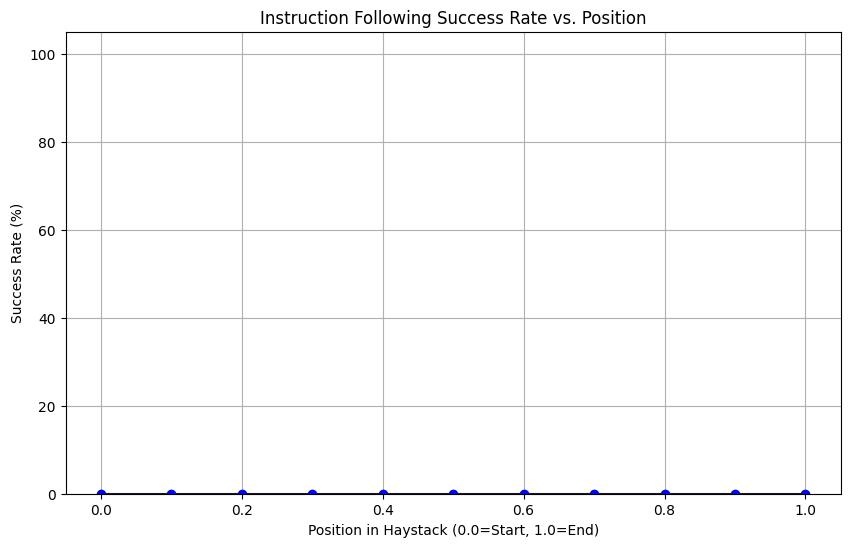

{0.0: {'logits': [-6.3125, -4.65625, -6.4375, -7.03125, -4.75, -7.78125, -6.5, -7.625, -6.15625, -5.90625, -6.5, -6.625, -5.96875, -5.3125, -5.59375, -6.71875, -5.84375, -6.78125, -7.25, -6.21875, -5.96875, -6.03125, -6.46875, -7.09375, -7.34375, -6.875, -6.375, -6.75, -7.0625, -6.34375, -6.0625, -6.09375, -6.1875, -5.375, -4.875, -7.21875, -6.4375, -6.625, -7.15625, -4.71875, -5.6875, -5.0625, -5.53125, -5.53125, -5.5, -6.15625, -6.28125, -6.78125, -6.90625, -6.5625, -5.53125, -6.75, -7.5625, -6.1875, -6.90625, -5.28125, -6.46875, -7.96875, -5.5, -7.90625, -6.84375, -5.59375, -5.28125, -7.28125, -5.3125, -6.59375, -6.03125, -5.6875, -5.6875, -5.21875, -5.5625, -5.8125, -6.03125, -5.375, -6.9375, -5.71875, -5.84375, -7.21875, -6.84375, -6.34375, -6.65625, -7.6875, -5.21875, -6.1875, -7.0, -7.15625, -4.90625, -6.5, -6.34375, -6.96875, -7.25, -5.21875, -7.21875, -6.125, -7.34375, -6.375, -5.6875, -6.8125, -6.59375, -5.65625], 'accuracy': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
def plot_dual_results(results):
    x = sorted(results.keys())
    
    # Prepare Data
    logit_means = [np.mean(results[pct]["logits"]) for pct in x]
    logit_stds = [np.std(results[pct]["logits"]) for pct in x]
    accuracy = [np.mean(results[pct]["is_correct"]) for pct in x]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Logits
    color = 'tab:blue'
    ax1.set_xlabel('Position (0.0=Start, 1.0=End)')
    ax1.set_ylabel('Logit Magnitude (CHERRY)', color=color)
    ax1.errorbar(x, logit_means, yerr=logit_stds, fmt='-o', color=color, label='Logit')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Accuracy on second axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy (Was CHERRY Top-1)', color=color)
    ax2.plot(x, accuracy, '-s', color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.1, 1.1) # Accuracy is 0 to 1

    plt.title(f"Instruction Salience: {instr_text}")
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- Execution ---
# Start with a shorter haystack to confirm the trend fast
sweep_data, examples = batched_position_sweep(model, instruction_set["first_word"][0], total_length=2048, samples_per_pos=100)
plot_dual_results(sweep_data)

In [33]:
print(examples)

{0.0: ['.CHERRY.  '], 0.1: ['\n\nCHERRY The novel'], 0.2: ['\n\nCHERRY The noisy'], 0.3: ['\n\n\nCHERRY \n'], 0.4: ['.CHERRY.  '], 0.5: ['\n\nCHERRY  The'], 0.6: ['\n\nCHERRY  The'], 0.7: ['\n\nCHERRY  This'], 0.8: ['\n\nCHERRY  The'], 0.9: ['\n\nCHERRY.  '], 1.0: ['\n\nCHERRY\n\nThe']}


In [59]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device count: {torch.cuda.device_count()}")

CUDA available: True
Device count: 1
